# 📌Import Module & Load Data

In [1]:
!pip install -q scikit-lego

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import scipy
import torch
import math
import sklearn

# preprocessing
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

# cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import median_absolute_error, roc_auc_score, roc_curve

# model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor
# from sklego.linear_model import LADRegression


# pipeline & ensemble
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklego.linear_model import LADRegression
from sklearn.base import clone

# parameter
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

In [3]:
df_train=pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
df_test=pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')

---

# ⚙️Setting

In [4]:
ids_test = df_test['id']
df_train = df_train.drop(columns='id')
df_test = df_test.drop(columns='id')

In [5]:
print(df_train.shape)
print(df_test.shape)

(10407, 12)
(6939, 11)


In [6]:
# print(df_train.isna().sum().any())
# print(df_test.isna().sum().any())

In [7]:
df_train.columns.to_list()

['allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average',
 'Hardness']

In [8]:
# df_train.describe()

In [9]:
seed = 42
n_splits = 10

# StratifiedKFold는 회귀 문제에는 적합하지 않음
# kf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=seed)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [10]:
# 주어진 데이터를 특성 행렬 (X)과 타겟 벡터 (y)로 분할
def generateXY(trainData):
    x = trainData.drop(columns='Hardness')
    y = trainData.Hardness
    return x,y

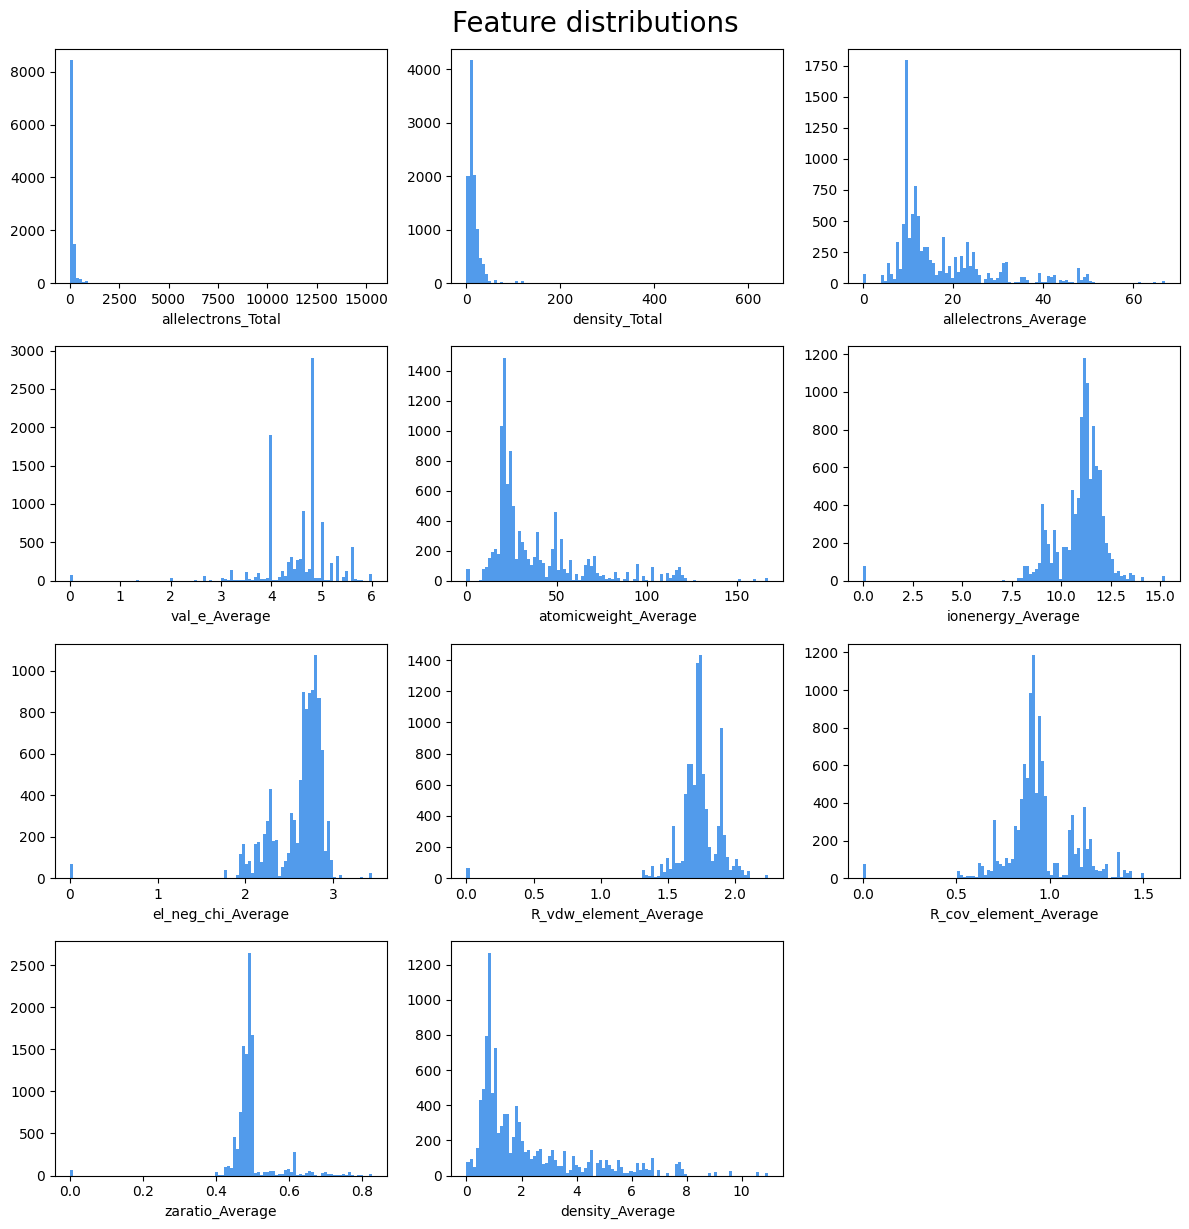

In [11]:
n = len(df_test.columns)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig , axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
for col, ax in zip(df_test.columns, axs.ravel()):
    if df_train[col].dtype == float:
        ax.hist(df_train[col], bins=100, color='#529BEB')
    else: #int
        vc = df_train[col].value_counts()
        ax.bar(vc.index, vc, color='#529BEB')
    ax.set_xlabel(col)

# 여분의 subplot 공간을 제거합니다.
for ax in axs.flatten()[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

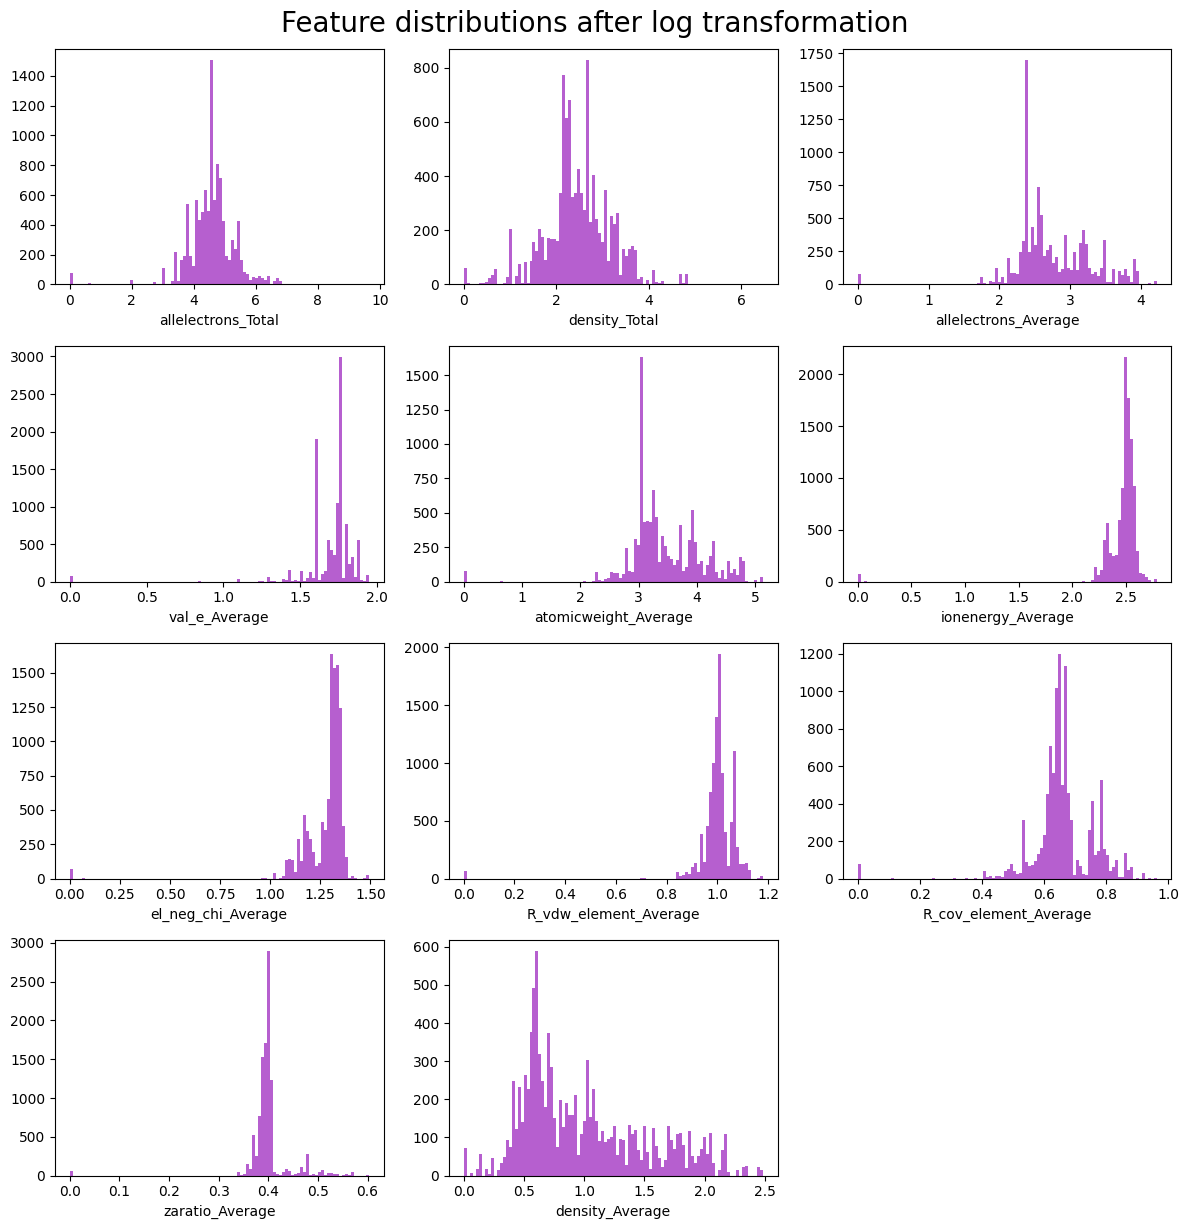

In [12]:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
for col, ax in zip(df_test.columns, axs.ravel()):
    ax.hist(np.log1p(df_train[col]), bins=100, color='#B65FCF')
    ax.set_xlabel(col)
    
# 여분의 subplot 공간을 제거합니다.
for ax in axs.flatten()[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

In [13]:
# # train과 test 데이터셋 유사성 분석
# # ROC-AUC 스코어가 0.5에 가까울수록 두 데이터셋이 비슷하다고 볼 수 있다.
# # https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation

# def adversarial_validation(dataset_1 = df_train, dataset_2 = df_test, label = 'Train-Test', kf=kf):

#     adv_train = dataset_1.drop('Hardness', axis = 1)
#     adv_test = dataset_2.copy()

#     adv_train['is_test'] = 0
#     adv_test['is_test'] = 1

#     adv = pd.concat([adv_train, adv_test], ignore_index = True)

#     adv_shuffled = adv.sample(frac = 1)

#     adv_X = adv_shuffled.drop('is_test', axis = 1)
#     adv_y = adv_shuffled.is_test

#     val_scores = []
#     predictions = np.zeros(len(adv))

#     for fold, (train_idx, val_idx) in enumerate(kf.split(adv_X, adv_y)):
    
#         adv_lr = XGBClassifier(random_state = 42)
#         adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])
        
#         val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
#         predictions[val_idx] = val_preds
#         val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
#         val_scores.append(val_score)
    
#     fpr, tpr, _ = roc_curve(adv['is_test'], predictions)
    
#     plt.figure(figsize = (10, 10))
#     sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
#     sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
#     plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.show()

# adversarial_validation()


---

# 🚥Feature Engineering

In [14]:
# def add_new_features(df):
#     df_col = df.columns.to_list()
#     if 'Hardness' in df_col:
#         Hardness_ = df['Hardness']
#         df = df.drop(columns='Hardness')



#     if 'Hardness' in df_col:
#         df['Hardness'] = Hardness_

#     return df

In [15]:
# df_train = add_new_features(df_train)
# df_test = add_new_features(df_test)

- 로그변환

In [16]:
# # 로그 변환을 적용할 feature 목록
# features_to_log_transform = ['age',
#                              'height(cm)',
#                              'weight(kg)',
#                              'waist(cm)',
#                              'eyesight(left)',
#                              'eyesight(right)',
#                              'hearing(left)',
#                              'hearing(right)',
#                              'systolic',
#                              'relaxation',
#                              'fasting blood sugar',
#                              'Cholesterol',
#                              'triglyceride',
#                              'HDL',
#                              'LDL',
#                              'hemoglobin',
#                              'Urine protein',
#                              'serum creatinine',
#                              'AST',
#                              'ALT',
#                              'Gtp',
#                              'dental caries'
#                              ]

# # Train set
# for feature in features_to_log_transform:
#     df_train[feature] = np.log1p(df_train[feature])

# # Test set
# for feature in features_to_log_transform:
#     df_test[feature] = np.log1p(df_test[feature])


---

# 🧺Feature Selection (with 6 techniques)

### ■ Filter Method

__A) Pearson Correlation:__ 두 변수 간의 선형 관계를 측정

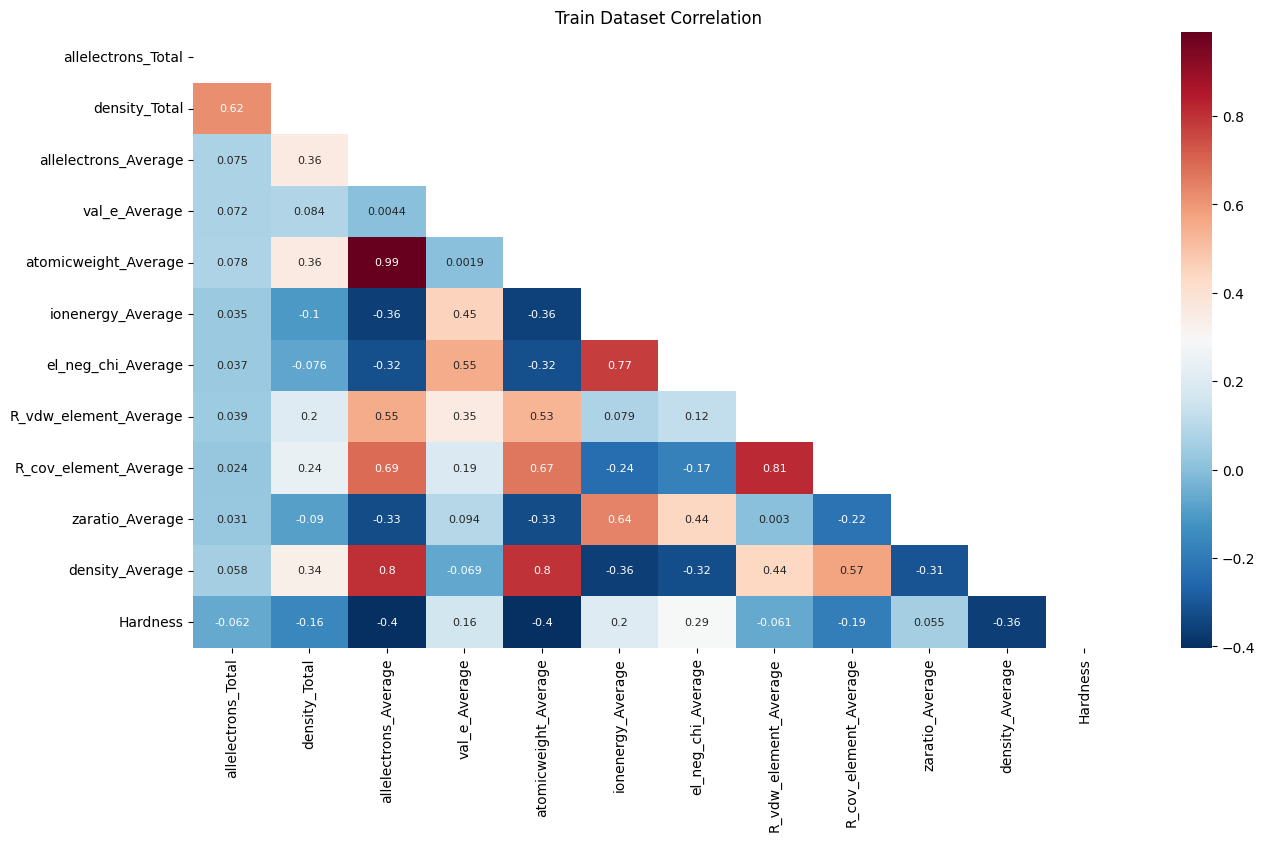

In [17]:
# corr() 메서드를 사용하여 특성 간의 상관 관계 행렬을 계산
trainCorr = df_train.corr()
mask = np.zeros_like(trainCorr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,8))
sns.heatmap(trainCorr, mask=mask, cmap='RdBu_r', annot=True, annot_kws={"size": 8}) # annot=True 매개변수를 사용하여 각 셀에 상관 관계 값을 표시
plt.title('Train Dataset Correlation')
plt.show()

In [18]:
# # target과 각 특성 간의 상관 관계를 계산
# # 특정 상관 관계 threshold를 넘는 특성들을 선택하여 내림차순 정렬
# threshold = 0.05
# corr=abs(trainCorr['smoking'])
# result = corr[corr>threshold]
# result.sort_values(ascending=False)

In [19]:
# # trainData에서 특성 간의 상관 관계를 계산하고, 상관 관계가 높은 특성들을 식별
# columns = df_train.columns.tolist()
# highCorrFeature = []
# for i in range(len(columns)-1, 0, -1):
#     if columns[i] in highCorrFeature:
#         continue
#     for j in range(0,i):
#         if columns[j] in highCorrFeature:
#             continue
#         # 같은 열과의 상관 관계를 계산하는 것을 피하기 위해 다른 열인지 확인
#         if i != j:
#             # columns[i],columns[j]의 상관 관계 계산
#             c = df_train[[columns[i],columns[j]]].corr()
#             # 상관 관계 행렬 c에서 columns[j] 열과 columns[i] 행에 해당하는 값 추출
#             val = c[columns[j]][0] # 이 값은 두 열 간의 상관 관계
#             if val > 0.5:
#                 print(f"{columns[i]} and {columns[j]} has high correlation {val}")
#                 highCorrFeature.append(columns[j])
                
# print(f"\nSize of original data: {df_train.shape[1]-1}, \nnumber of high correlation features: {len(highCorrFeature)}")

In [20]:
# # 높은 상관 관계를 가진 특성들을 제거한 데이터를 x에 저장
# x = df_train.drop(columns=highCorrFeature)
# x = x.drop(columns='smoking')

# # 높은 상관 관계를 가진 특성들을 제외한 특성들의 목록
# featurePC = x.columns.tolist()
# print(f"Selected features: {len(featurePC)} / {featurePC}")

# # 이전에 정의한 generateXY 함수를 사용하여 특성 행렬 x와 타겟 벡터 y를 생성
# x,y = generateXY(df_train)

# # cv 계산
# cv_feature(x,y,featurePC,'Pearson Correlation')

In [21]:
# featurePC = ['age', 'height(cm)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'systolic', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'Urine protein', 'serum creatinine', 'AST', 'Gtp', 'dental caries']

__❌B) Variance Inflation Factor (VIF):__ 다중 공선성 평가
- 다중공선성: 회귀분석에서 독립변수들 간에 강한 상관관계가 나타나는 문제
- 이진 분류 문제에서 사용하는 로지스틱 회귀나 결정 트리 기반 모델 등은 변수 간의 상관관계가 높아도 모델의 성능에 크게 영향을 미치지 않는 경우가 많음

In [22]:
# # VIF를 사용하여 다중공선성을 확인
# # VIF가 일정 임계값을 넘는 특성들을 제거하여 모델에 사용할 특성을 선택

# from statsmodels.stats.outliers_influence import variance_inflation_factor
# def cal_vif(x):
#     # 일반적으로 VIF 10 이상인 특성은 다중공선성 가능성이 높다고 판단
#     thresh = 10
#     output = pd.DataFrame()
#     k = x.shape[1]
#     vif = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    
#     # VIF가 임계값을 넘는 특성 제거
#     for i in range(k):
#         a = np.argmax(vif)
#         print(f'Max vif is for variable Index: {a}')
#         if (vif[a]<=thresh):
#             break
#         if (i==1):
#             output = x.drop(x.columns[a],axis=1)
#             vif = [variance_inflation_factor(output.values,j) for j in range(output.shape[1])]
#         elif (i>1):
#             output = output.drop(output.columns[a],axis=1)
#             vif = [variance_inflation_factor(output.values,j) for j in range(output.shape[1])]
#     return output

# x,y = generateXY(df_train)
# x = cal_vif(x) # VIF 계산하여 다중공선성 높은 특성을 제거한 결과를 x에 저장
# featureVIF = x.columns.tolist()
# print(f"Selected features: {len(featureVIF)} / {featureVIF}")
# cv_feature(x,y,featureVIF,'Variance Inflation Factor')

### ■ Wrapper Method

__A) Step Forward Selection:__ 특성을 하나씩 추가하면서 모델의 성능을 측정하고 최상의 특성 조합을 찾는 방법

In [23]:
# # 특성 선택에 사용되는 Sequential Feature Selector (SFS)를 활용하는 예제
# # 특성 스텝마다 성능을 확인하고 최고의 성능을 나타낸 특성을 뽑기 위해 catboost를 씀
# # 최후에는 선택된 특성들만을 이용하여 RandomForestRegressor로 학습
# from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# x,y = generateXY(df_train)

# clf = CatBoostClassifier(random_state=seed, logging_level = 'Silent')

# # SequentialFeatureSelector 객체 생성
# sfs1 = sfs(clf, k_features=5, forward=True, floating=False, verbose=1, cv=3) # SFS 초기화

# # SFS를 훈련 데이터에 적용
# sfs1 = sfs1.fit(x, y) 

In [24]:
# # SFS를 통해 선택된 특성들을 확인하고, 이를 사용하여 cv 계산
# feat_cols = list(sfs1.k_feature_idx_)
# featureSFS = x.columns[feat_cols].tolist()

# print(f"Selected features: {len(featureSFS)} / {featureSFS}")
# cv_feature(x, y, featureSFS, 'Step Forward Selection')

__B) Backward elimination:__ 가장 덜 중요한 특성을 하나씩 제거하면서 모델의 성능을 측정, 최적의 특성 집합을 찾을 때까지 반복
- 선형 회귀 모델을 기반으로 하기 때문에, 이진 분류 문제에 직접 적용하기는 어려움

__C) Recursive Feature elimination:__ 재귀적 특성 제거 (RFE)는 지정된 특성 수에 도달할 때까지 모델을 학습하고 가장 약한 특성(들)을 제거
-  RFECV는 Recursive Feature Elimination과 Cross-Validated selection을 통해 최적의 특성 수를 선택

In [25]:
# from sklearn.feature_selection import RFECV

# x, y = generateXY(df_train)

# # CatBoostClassifier 객체 생성
# model = CatBoostClassifier(random_state=seed, logging_level = 'Silent')

# # RFECV를 이용한 Backward Elimination
# rfecv = RFECV(estimator=model, step=1, cv=5)  # step=1은 한 번에 하나의 특성을 제거하겠다는 의미이며, cv=5는 5-fold cross-validation을 수행하겠다는 의미입니다.
# rfecv = rfecv.fit(x, y)

# # 선택된 특성 확인
# featureBE = x.columns[rfecv.support_].tolist()

# print(f"Selected features: {len(featureBE)} / {featureBE}")

# # 선택된 특성으로 cv_feature 함수를 통해 교차 검증 수행
# cv_feature(x, y, featureBE, 'Backward Elimination')

### ■ Embedded Method
모델 훈련 과정에서 특성 선택을 수행하는 방법
> 임베디드 방법은 모델의 훈련 과정에서 특성의 중요도를 반복적으로 평가

1) LogisticRegressionCV 모델을 사용한 Lasso 방법
- 선형 관계를 가정하고 있기 때문에, 특성들이 선형적으로 목표 변수와 관련이 있을 때 유용
- Lasso는 특성의 수를 크게 줄일 수 있어 해석이 쉬운 모델을 만들 수 있음
- 하지만, 특성 간 복잡한 상호작용을 잡아내기 어려움

In [26]:
# from sklearn.linear_model import LogisticRegressionCV

# x,y = generateXY(df_train)
# clf = LogisticRegressionCV(cv=5, Cs=200, tol=1e-4, fit_intercept=False, penalty='l1', solver='liblinear')
# clf.fit(x,y)
# print("Best score: ", clf.score(x,y))

# coef = pd.Series(clf.coef_[0], index=x.columns)
# print("Lasso picked " + str(sum(coef != 0))+ " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

# imp_coef = coef.sort_values()
# featureEM = imp_coef[imp_coef>0].index.tolist()

# print(f"Selected features: {len(featureEM)} / {featureEM}")
# cv_feature(x,y,featureEM,'Embedded Method')

2) CatBoostClassifier 모델을 사용한 특성 중요도 방법
- 비선형 관계와 특성 간의 복잡한 상호작용을 잘 잡아냄
- 특성 중요도를 직접적으로 제공하므로, 어떤 특성이 모델의 예측에 중요한 역할을 하는지 파악하는 데 유용

In [27]:
# # CatBoostClassifier 객체 생성
# clf = CatBoostClassifier(random_state=seed, logging_level = 'Silent')

# # 모델 학습
# clf.fit(x, y)

# # 특성 중요도 계산
# feature_importances = clf.feature_importances_
# sorted_idx = feature_importances.argsort()

# # 시각화
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
# plt.yticks(range(len(feature_importances)), x.columns[sorted_idx])
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('Feature Importance Plot')
# plt.show()

In [28]:
# # 특성 중요도를 기반으로 특성 선택
# featureEM = x.columns[feature_importances > 0.9].tolist()

# print(f"Selected features: {len(featureEM)} / {featureEM}")

# # 선택된 특성으로 cv_feature 함수를 통해 교차 검증 수행
# cv_feature(x, y, featureEM, 'Embedded Method')

### ■ Final Feature Selection

In [29]:
# # 다양한 특성 선택 기법을 통해 선택된 특성들을 모아서 특성 중요도 시각화
# allfeature = featurePC + featureSFS + featureBE + featureEM
# feature, count = np.unique(allfeature, return_counts=True) # 각 특성 빈도 카운트
# featureCount = pd.DataFrame(count,index=feature, columns=['Count'])
# featureCount = featureCount.sort_values(by=['Count'])
# featureCount.plot(kind = "barh") # 막대그래프 표현
# plt.rcParams["figure.figsize"] = (20,10) # 크기 조정
# plt.title("Feature importance based on all selection techniques")

In [30]:
# # 특정 임계값을 넘는 특성들로 최종 모델을 학습하여 cv 계산
# selected_features = []

# for i, val in enumerate(feature):
#     if count[i] > 1:
#         selected_features.append(val)
# print(f"Final Selected features: {len(selected_features)} / {selected_features}")
# X,y = generateXY(df_train)
# clf = cv_feature(X,y,selected_features,"Final model")

---

# ⚠️Pre-process

---

# 🎰Model Optimization (with Optuna)

__- 모델 학습하는 함수 정의__

In [31]:
# def optimize_params(objective, n_trials=100, seed=42):
#     # Pruner 설정
#     pruner = MedianPruner(
#         n_warmup_steps=10,  # 첫 10회 trial은 pruner가 적용되지 않습니다.
#         interval_steps=1,  # pruner가 적용되는 간격을 설정합니다. 
#     )

#     # Sampler 설정
#     sampler = TPESampler(
#         seed=seed  # 재현가능성을 보장하기 위한 시드 값 설정
#     )

#     # Run optimization.
#     study = optuna.create_study(
#         direction='maximize',
#         pruner=pruner,
#         sampler=sampler
#     )
#     study.optimize(objective, n_trials=n_trials)

#     # Get best parameters from study
#     best_params = study.best_params

#     print(f'Best parameters: {best_params}')
#     print(f'Best ROC AUC Score: {study.best_value:.5f}')

A) RandomForestClassifier

In [32]:
# def objectiveRF(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 5, 50),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
#         'max_features': trial.suggest_categorical('max_features', ["sqrt", "log2", None]),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 100, 2000),
#         'max_samples': trial.suggest_float('max_samples', 1e-2, 1, log=True),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True]),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'n_jobs': -1
#     }

#     # Initialize and fit the model.
#     model = RandomForestClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
#     # print(f'RandomForestClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveRF, n_trials=100, seed=42)

B) Extra Trees

In [33]:
# def objectiveET(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#         'max_depth': trial.suggest_int('max_depth', 2, 30),
#         'min_impurity_decrease': trial.suggest_float('min_impurity_decrease',1e-10, 1e-2, log=True),
#         # 'min_impurity_decrease': trial.suggest_float('min_impurity_decrease',0.0, 1.0),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
#         'max_features': trial.suggest_float ('max_features', 0.1, 1.0),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 100, 3000),
#         'max_samples': trial.suggest_float('max_samples', 1e-5, 1.0, log=True),
#         # 'max_samples': trial.suggest_float('max_samples', 1e-3, 3e-1, log=True),
#         'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
#         # 'min_weight_fraction_leaf': trial.suggest_float ('min_weight_fraction_leaf', 1e-3, 1e-1),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True]),
#         'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
#         'n_jobs': -1,
#     }

#     # Initialize and fit the model.
#     model = ExtraTreesClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
#     # print(f'ExtraTreesClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveET, n_trials=100, seed=42)

C) Hist Gradient Boosting

In [34]:
# def objectiveHGB(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'l2_regularization': trial.suggest_float('l2_regularization', 1e-5, 10.0, log=True),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
#         'max_iter': trial.suggest_int('max_iter', 100, 2000),
#         'max_depth': trial.suggest_int('max_depth', 1, 100),
#         'max_bins': trial.suggest_int('max_bins', 2, 255),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 2000),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 255),
#     }

#     # Initialize and fit the model.
#     model = HistGradientBoostingClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
#     # print(f'HistGradientBoostingClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveHGB, n_trials=100, seed=42)

D) XGBClassifier

In [35]:
# def objectiveXGB(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         # num_boost_round: GBM의 n_estimators와 같은 파라미터
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 1, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'gamma': trial.suggest_float('gamma', 0.0, 5.0),
#         'alpha': trial.suggest_float('alpha', 0.0, 10.0),
#         'lambda': trial.suggest_float('lambda', 0.0, 10.0),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True), # eta [defalut: 0.3, alias: learning_rate] 
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0), 
#         'tree_method': 'hist',
#         'device': 'cuda',
#         'objective': 'binary:logistic'
#     }

#     # Initialize and fit the model.
#     model = XGBClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
#     # print(f'XGBClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveXGB, n_trials=100, seed=42)

E) LightGBM

In [36]:
# def objectiveLGBM(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         "objective": "binary",
#         "metric": "auc",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
#         "subsample": trial.suggest_float("subsample", 0.1, 1.0),
#         "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
#         'n_estimators': trial.suggest_int("n_estimators", 50, 3000),
#         'max_depth': trial.suggest_int('max_depth', -1, 50),
#         'device_type': 'gpu'
#     }

#     # Initialize and fit the model.
#     model = LGBMClassifier(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
#     print(f'LGBMClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveLGBM, n_trials=100, seed=42)

F) CatBoostClassifier

In [37]:
# def objectiveCat(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1200),
#         'depth': trial.suggest_int('depth', 5, 15),
#         'learning_rate': trial.suggest_float("learning_rate", 2e-2, 8e-2, log=True),
#         'random_strength': trial.suggest_float('random_strength', 0.7, 1.3, log=True),
#         'bagging_temperature': trial.suggest_float("bagging_temperature", 0.2, 0.6, log=True),
#         'border_count': trial.suggest_int('border_count', 100, 200),
#         'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 1, 6),
#         'scale_pos_weight':trial.suggest_float("scale_pos_weight", 1.2, 1.9, log=True),
#     }

#     # Initialize and fit the model.
#     model = CatBoostClassifier(**params, random_state=seed, logging_level = 'Silent')
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
#     # print(f'CatBoostClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveCat, n_trials=100, seed=42)

In [38]:
# def objectiveCat(trial):
#     # Define the hyperparameters for the trial.
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1000),
#         'depth': trial.suggest_int('depth', 5, 7),
#         'learning_rate': trial.suggest_float("learning_rate", 2e-2, 8e-2, log=True),
#         'random_strength': trial.suggest_float('random_strength', 0.6, 0.9),
#         'bagging_temperature': trial.suggest_float("bagging_temperature", 0.2, 0.7),
#         'border_count': trial.suggest_int('border_count', 130, 170),
#         'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 4, 6),
#         'scale_pos_weight':trial.suggest_float("scale_pos_weight", 1.2, 1.8),
#     }

#     # Initialize and fit the model.
#     model = CatBoostClassifier(**params, random_state=seed, logging_level = 'Silent')
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
#     # print(f'CatBoostClassifier has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveCat, n_trials=100, seed=42)

G) Logistic Regression

In [39]:
# import warnings
# warnings.filterwarnings('ignore')

# # max_iter는 Gradient Descent 방식을 반복해서 몇번 수행할 것인가 인데, 
# # 이게 일단 수렴(Convergence)하게 되면 횟수를 늘려도 성능이 거의 달라지지 않음
# def objectiveLR(trial):
#     # Define the hyperparameters for the trial.
#     penalty_solver = trial.suggest_categorical('penalty_solver', [
#         ('l1', 'liblinear'), 
#         ('l1', 'saga'), 
#         ('l2', 'newton-cg'), 
#         ('l2', 'lbfgs'), 
#         ('l2', 'sag'), 
#         ('l2', 'saga'), 
#         ('elasticnet', 'saga'),
#         ('none', 'newton-cg'),
#         ('none', 'lbfgs'),
#         ('none', 'sag'),
#         ('none', 'saga')
#     ])

#     penalty, solver = penalty_solver

#     if penalty == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
#     else:
#         l1_ratio = None

#     params = {
#         'max_iter': trial.suggest_int('max_iter', 100, 1000),
#         'C': trial.suggest_float('C', 1e-5, 10, log=True),
#         'penalty': penalty,
#         'solver': solver,
#         'l1_ratio': l1_ratio,
#         'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#         'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
#         'n_jobs': -1
#     }



#     # Initialize and fit the model.
#     model = LogisticRegression(**params, random_state=seed)
#     X, y = generateXY(df_train)
#     scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
# #     print(f'LogisticRegression has ROC AUC Score(Avg) = {np.mean(scores):.7f} +/- {np.std(scores) * 2:.5f}')
#     return np.mean(scores)

# optimize_params(objectiveLR, n_trials=100, seed=42)

---

# 📈Train

In [40]:
# # optuna로 뽑은 최적화 파라미터

# opt_rf_params = {'n_estimators': 947, 
#                  'max_depth': 29, 
#                  'min_samples_split': 31, 
#                  'min_samples_leaf': 9, 
#                  'max_features': None, 
#                  'max_leaf_nodes': 1839, 
#                  'max_samples': 0.8650030717488943, 
#                  'bootstrap': True, 
#                  'criterion': 'entropy',
#                  'n_jobs': -1
#                  }
# opt_et_params = {'n_estimators': 709, 
#                  'max_depth': 29, 
#                  'min_impurity_decrease': 2.37677144655935e-05, 
#                  'criterion': 'gini', 
#                  'min_samples_split': 16, 
#                  'min_samples_leaf': 6, 
#                  'max_features': 0.9622645147955742, 
#                  'max_leaf_nodes': 1672, 
#                  'max_samples': 0.09822322294168621, 
#                  'min_weight_fraction_leaf': 0.000656642715024573, 
#                  'bootstrap': True, 
#                  'class_weight': None,
#                  'n_jobs': -1,
#                  } # 0.85538
# opt_hgb_params = {'l2_regularization': 7.086578943242248, 
#                   'learning_rate': 0.016691512438799662, 
#                   'max_iter': 1849, 
#                   'max_depth': 31, 
#                   'max_bins': 247, 
#                   'min_samples_leaf': 631, 
#                   'max_leaf_nodes': 91
#                   } # 0.86993
# opt_xgb_params = {'n_estimators': 973, 
#                   'max_depth': 10, 
#                   'min_child_weight': 3, 
#                   'subsample': 0.9504791909105347, 
#                   'colsample_bytree': 0.3028813045040783, 
#                   'gamma': 0.9272085943572528, 
#                   'alpha': 6.058561922964304, 
#                   'lambda': 7.442253995706032, 
#                   'learning_rate': 0.034608357960129406, 
#                   'scale_pos_weight': 5.066377770811329,
#                   'tree_method': 'hist',
#                   'device': 'cuda',
#                   'objective': 'binary:logistic',
#                   'n_jobs': -1,
#                   } # 0.87260
# opt_lgbm_params = {'reg_alpha': 1.7862129552684525e-06, 
#                    'reg_lambda': 4.457649510795302e-07, 
#                    'num_leaves': 231, 
#                    'colsample_bytree': 0.23633545420416763, 
#                    'subsample': 0.41304778630564337, 
#                    'subsample_freq': 10, 
#                    'min_child_samples': 70, 
#                    'learning_rate': 0.011773171567527234, 
#                    'n_estimators': 2620, 
#                    'max_depth': 18,
#                    "objective": "binary",
#                    "metric": "auc",
#                    "verbosity": -1,
#                    "boosting_type": "gbdt",
#                    'device_type': 'gpu'
#                    }
# opt_cat_params = {'iterations': 980, 
#                   'depth': 7, 
#                   'learning_rate': 0.07645498037017964, 
#                   'random_strength': 0.6910564067238075, 
#                   'bagging_temperature': 0.371867116122552, 
#                   'border_count': 155, 
#                   'l2_leaf_reg': 5, 
#                   'scale_pos_weight': 1.5475544409461044,
#                   'logging_level': 'Silent'
#                   }

# # optuna에서 계속 같은 점수로 수렴됨. 한계가 있는듯
# opt_lr_params = {'penalty':'none', 
#                  'solver': 'newton-cg', 
#                  'max_iter': 804, 
#                  'C': 0.008675998270633417, 
#                  'fit_intercept': True, 
#                  'class_weight': None
#                  } # 0.834328887524651

In [41]:
# Define the original models.
# MedAE와 같은 중앙값 기반의 오차 측정 방법은 모델의 objective로 설정하기 어려움 (미분 가능한 함수가 아니기 때문)
origin_models = {
    'xgb_mae': XGBRegressor(random_state = seed, objective = 'reg:absoluteerror'),
    'xgb_quant': XGBRegressor(random_state = seed, objective = 'reg:quantileerror', quantile_alpha = .5),
    'lgb_mae': LGBMRegressor(random_state = seed, objective = 'mae'),
    'lgb_quant': LGBMRegressor(random_state = seed, objective = 'quantile', alpha = .5),
    'cb_mae': CatBoostRegressor(random_state = seed, verbose = 0, objective = 'MAE'),
    'cb_quant': CatBoostRegressor(random_state = seed, verbose = 0, objective = 'Quantile:alpha=0.5'),
    'hgb': HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error')
}

In [42]:
# # Define the pipelines
# log_transformer = FunctionTransformer(np.log1p)
# pipelines = {
#     "Random Forest": make_pipeline(RobustScaler(),
#                                    RandomForestClassifier(random_state=seed, n_jobs=-1)),
#     "Extra Trees": make_pipeline(log_transformer,
#                                  ExtraTreesClassifier(random_state=seed, n_jobs=-1)),
#     "Hist Gradient Boosting": make_pipeline(HistGradientBoostingClassifier(random_state=seed)),
#     "XGBoost": make_pipeline(QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=seed),
#                              XGBClassifier(random_state=seed, n_jobs=-1)),
#     "LightGBM": make_pipeline(LGBMClassifier(random_state=seed, verbosity=-1)),
#     "CatBoost": make_pipeline(RobustScaler(),
#                               CatBoostClassifier(random_state=seed, logging_level = 'Silent')),
#     # "LogisticRegression": LogisticRegression(random_state=seed, max_iter=2000, n_jobs=-1),
# }

### __1) Voting 앙상블__ (with Weights)
- 모델별 가중치 추출

### 모델별로 어떤 스케일이 좋은지 판단

In [43]:
def cv_oof_preds(models, X, y, cv):
    """
    Perform cross-validation for each model and generate out-of-fold predictions.

    Args:
    - models: a dictionary of Scikit-learn models
    - X: features
    - y: target variable
    - cv: cross-validation splitter

    Returns:
    - a DataFrame of out-of-fold predictions
    - a list of average MedAE scores for each model
    """
    # Create a DataFrame to store out-of-fold predictions.
    oof_predictions = pd.DataFrame(index=y.index)

    # Create an empty list to store the average MedAE scores
    avg_medae_scores = []

    # Iterate over each model and compute cross-validated predictions.
    for name, model in models.items():
        # Create an empty array to store the out-of-fold predictions
        oof_preds = np.zeros(y.shape[0])

        # Create an empty list to store the MedAE scores
        medae_scores = []

        # Perform cross-validation
        for train_index, valid_index in cv.split(X, y):
            # Clone the model to ensure that it's reset for each fold
            model_clone = clone(model)

            # Split the data
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # Fit the model
            model_clone.fit(X_train, y_train)

            # Compute predictions
            preds = model_clone.predict(X_valid)

            # Store predictions for this fold in oof_preds
            oof_preds[valid_index] = preds

            # Compute the MedAE score and append it to the list
            score = median_absolute_error(y_valid, preds)
            medae_scores.append(score)

        # Store the predictions in the DataFrame
        oof_predictions[name] = oof_preds

        # Store the average MedAE score and print
        avg_medae_score = np.mean(medae_scores)
        avg_medae_scores.append(avg_medae_score)
        
        print(f"{name} MedAE Score(Avg): {avg_medae_score:.7f}")
    print(f"★Models MedAE Score(Avg) = {np.mean(avg_medae_scores):.7f} ± {np.std(avg_medae_scores) * 2:.5f}")

    return oof_predictions, avg_medae_scores


In [44]:
def apply_scaling_and_cv(models, X, y, cv):
    """
    Apply different scaling methods, log transformation, and no scaling to the data and perform cross-validation for each model.
    """
    # Define the scaling methods
    scalers = {
        'NoScaling': None,  # Add no scaling
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler(),
        'QuantileTransformer': QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=seed),
        'LogTransform': None  # Add log transformation
    }

    # Create dictionaries to store the results
    all_oof_predictions = {}
    all_avg_medae_scores = {}

    # Apply each scaling method
    for scaler_name, scaler in scalers.items():
        print(f"[Applying {scaler_name}...]")

        if scaler_name == 'NoScaling':
            # Do not scale the features
            X_scaled = X.copy()
        elif scaler_name == 'LogTransform':
            # Apply log transformation
            X_scaled = np.log1p(X)
        else:
            # Scale the features
            X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        # Perform cross-validation and generate out-of-fold predictions
        oof_predictions, avg_medae_scores = cv_oof_preds(models, X_scaled, y, cv)
        print()
        print("="*60)
        print()

        # Store the results
        all_oof_predictions[scaler_name] = oof_predictions
        all_avg_medae_scores[scaler_name] = avg_medae_scores

    # Print the best scaling method for each model
    print(f"[⚠️The best scaling]")
    for model_name in models.keys():
        best_method, best_score = min(
            ((method, scores[i]) for method, scores in all_avg_medae_scores.items() for i, model in enumerate(models) if model == model_name),
            key=lambda x: x[1]
        )
        print(f"For {model_name}, the best scaling method is {best_method} with MedAE: {best_score:.7f}")


    return all_oof_predictions, all_avg_medae_scores


In [45]:
# LADRegression 모델을 사용하여 각 모델의 예측값에 대한 가중치를 계산하는 방식
def perform_voting(models, X, y, cv):
    oof_predictions,_ = cv_oof_preds(models, X, y, cv)

    # Compute the weights using LAD Regression.
    weights = LADRegression().fit(oof_predictions, y).coef_
    display(pd.DataFrame(weights, index=list(oof_predictions.columns), columns=['weight per model']))

    # Create a voting regressor.
    voting_reg = VotingRegressor(estimators=list(models.items()), weights=weights.tolist())

    # Compute cross-validated Median Absolute Error.
    # Scikit-learn의 교차 검증 함수는 높은 값이 좋은 것으로 간주되므로, 모든 손실 함수에서는 'neg' 접두사가 붙음
    voting_score = -1 * cross_val_score(voting_reg, X, y, scoring='neg_median_absolute_error', cv=cv)
    print(f"★VotingRegressor MedAE Score(Avg): {np.mean(voting_score):.7f} ± {np.std(voting_score) * 2:.5f}")

    # Fit the model to the training data.
    voting_reg.fit(X, y)

    return voting_reg

In [46]:
############ 로그 변환 포함 어떤 스케일링이 제일 효과적인지 계산 #############
# Apply the function to compute out-of-fold predictions and average ROC AUC scores
X, y = generateXY(df_train)

all_oof_predictions, all_avg_medae_scores = apply_scaling_and_cv(origin_models, X, y, kf) # Modify Models

# For each scaling method, create a VotingClassifier based on the out-of-fold predictions
for scaler_name in all_oof_predictions.keys():
    print(f"\nApplying VotingClassifier for {scaler_name}...")

    # Get the out-of-fold predictions for the current scaling method
    oof_predictions = all_oof_predictions[scaler_name]

    # Fit a Ridge Classifier to compute the weights.
    weights = LADRegression().fit(oof_predictions, y).coef_
    print(pd.DataFrame(weights, index = list(oof_predictions), columns = ['weight per model']))

    # Create a voting classifier.
    voting_reg = VotingRegressor(estimators=list(origin_models.items()), weights=weights.tolist()) # Modify Models

    # Compute cross-validated
    voting_score = -1 * cross_val_score(voting_reg, X, y, scoring='neg_median_absolute_error', cv=kf)
    print(f"★VotingRegressor MedAE Score(Avg) {np.mean(voting_score):.7f} ± {np.std(voting_score) * 2:.5f}")

    # Fit the model to the training data.
    voting_reg.fit(X, y)


[Applying NoScaling...]
xgb_mae MedAE Score(Avg): 0.5532197
xgb_quant MedAE Score(Avg): 0.5486504
lgb_mae MedAE Score(Avg): 0.5342273
lgb_quant MedAE Score(Avg): 0.5266510
cb_mae MedAE Score(Avg): 0.5464936
cb_quant MedAE Score(Avg): 0.5464936
hgb MedAE Score(Avg): 0.5300827
★Models MedAE Score(Avg) = 0.5408312 ± 0.01911


[Applying StandardScaler...]
xgb_mae MedAE Score(Avg): 0.5500363
xgb_quant MedAE Score(Avg): 0.5494097
lgb_mae MedAE Score(Avg): 0.5327985
lgb_quant MedAE Score(Avg): 0.5263011
cb_mae MedAE Score(Avg): 0.5478945
cb_quant MedAE Score(Avg): 0.5478945
hgb MedAE Score(Avg): 0.5295325
★Models MedAE Score(Avg) = 0.5405525 ± 0.01943


[Applying MinMaxScaler...]
xgb_mae MedAE Score(Avg): 0.5479008
xgb_quant MedAE Score(Avg): 0.5508841
lgb_mae MedAE Score(Avg): 0.5344139
lgb_quant MedAE Score(Avg): 0.5251707
cb_mae MedAE Score(Avg): 0.5482906
cb_quant MedAE Score(Avg): 0.5482906
hgb MedAE Score(Avg): 0.5272157
★Models MedAE Score(Avg) = 0.5403095 ± 0.02046


[Applying RobustS

In [47]:
# '''
# Voting 앙상블 예측값 추출
# '''
# X, y = generateXY(df_train)
# voting_reg = perform_voting(origin_models, X, y, kf)

In [48]:
# VotingRegressor MedAE Score(Avg): 0.5296128 ± 0.04108
# VotingRegressor MedAE Score(Avg): 0.5276154 ± 0.06023

### __2) Hill_Climbing 앙상블__ (with Weights)

In [49]:
def hill_climbing(x, y, x_test):

    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = median_absolute_error(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])} 

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [median_absolute_error(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = median_absolute_error(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = median_absolute_error(y, potential_ensemble)
                if cv_score < potential_new_best_cv_score: 
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True

    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds

    return [hill_ens_pred_1, hill_ens_pred_2]

In [50]:
def perform_hill_climbing(models, X, y, cv):
    hill_ens_cv_scores, hill_ens_preds = list(), list()

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[test_idx]

        preds_train = {}
        preds_test = {}
        for name, model in models.items():
            trained_model = model.fit(X_train_fold, y_train_fold)
            preds_train[name] = trained_model.predict(X_val_fold)
            preds_test[name] = trained_model.predict(df_test)

        oof_df_train, oof_df_test = pd.DataFrame(preds_train), pd.DataFrame(preds_test)

        hill_results = hill_climbing(oof_df_train, y_val_fold, oof_df_test)

        hill_ens_score_fold = median_absolute_error(y_val_fold, hill_results[0])
        hill_ens_cv_scores.append(hill_ens_score_fold)
        hill_ens_preds.append(hill_results[1])

        print('Fold', i+1, '==> Hill Climbing Ensemble oof MedAE score is ==>', hill_ens_score_fold)

    print(f"★The hill climbing ensemble oof MedAE score over the {n_splits}-folds is {np.mean(hill_ens_cv_scores):.7f} ± {np.std(hill_ens_cv_scores) * 2:.5f}")
    return hill_ens_preds

- 힐클라이밍 앙상블 수행

In [51]:
# X, y = generateXY(df_train)

# hill_ens_preds = perform_hill_climbing(origin_models, X, y, kf)

In [52]:
# ★The hill climbing ensemble oof MedAE score over the 5-folds is 0.5192183 ± 0.03398
# ★The hill climbing ensemble oof MedAE score over the 10-folds is 0.5027685 ± 0.04291

---

# 📝Final Submit

In [53]:
# # Voting 앙상블 예측값 추출
# # Make predictions on test data. 
# test_predictions = voting_reg.predict(df_test)

In [54]:
# Hill_Climbing 앙상블 예측값 추출
test_predictions = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)

NameError: name 'hill_ens_preds' is not defined

In [ ]:
df_submit = pd.DataFrame({'id':ids_test,'Hardness': test_predictions})
df_submit.head()

In [ ]:
df_submit.to_csv('submission.csv', index=False)